# Numerical Gaussian curvature with Pytorch
### James Golden

In order to validate measuring curvature numerically with Pytorch, the curvature for a single-sheeted hyperboloid is computed and compared with the theoretical values. The canonical example for curvature is a sphere, but in that case the curvarture values are the same at every point. This hyperboloid curvature is different at every point.

## One-sheeted hyperboloid
https://mathworld.wolfram.com/One-SheetedHyperboloid.html

![](https://mathworld.wolfram.com/images/eps-gif/Hyperboloid1Sheeted2_500.gif) 

![](https://mathworld.wolfram.com/images/equations/One-SheetedHyperboloid/NumberedEquation1.gif) where *z = c* * u.

### Gaussian curvature at each point:

![](https://mathworld.wolfram.com/images/equations/One-SheetedHyperboloid/Inline50.gif)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

In [2]:
def hyperboloid(a=.1, c=.2):
    # generate single sheet hyperboloid
    
    stepsz = .125/6;
    stpt = -2.875/4+stepsz/2
    endpt = 2.875/4-stepsz/2;#-1.275;%-.9+0.5
    endpt

    (endpt-stpt)//stepsz


    numpts = 30
    maxp = 1.5
    # nx, ny, nz = (numpts, numpts, numpts)
    xl = np.linspace(stpt, endpt, 1+int((endpt-stpt)//stepsz))
    yl = np.linspace(stpt, endpt, 1+int((endpt-stpt)//stepsz))
    # zl = np.linspace(0, endpt, numpts)

    xv, yv = np.meshgrid(xl, yl)
    zv = np.sqrt((c**2)*((np.power(xv,2))/(a**2) + (np.power(yv,2))/(a**2)- 1))
    
    return xv,yv,zv

In [3]:
def grad_hess(xv, yv, zv, a=.1, c=.2):
    
    ygrad = np.zeros(np.shape(xv)+(2,))
    yhess = np.zeros(np.shape(xv)+(4,))


    for xindi in range(len(xv[0,:])):
        for yindi in range(len(yv[0,:])):
            x = torch.autograd.Variable(torch.tensor([xv[xindi,yindi],yv[xindi,yindi]],dtype=torch.float64),requires_grad=True)
            y = torch.sqrt_((c**2)*((x[0]**2)/(a**2) + (x[1]**2)/(a**2) - 1))
            x_1grad, = grad(y, x, create_graph=True,retain_graph=True)
            ygrad[xindi,yindi,:]=x_1grad.data.numpy()

            x_2grad0, = grad(x_1grad[0], x, create_graph=True)
            x_2grad1, = grad(x_1grad[1], x, create_graph=True)
            yhess[xindi,yindi,:2]=x_2grad0.data.numpy()
            yhess[xindi,yindi,2:4]=x_2grad1.data.numpy()
            
    return ygrad, yhess

In [4]:
def curvature_nd(ygrad,yhess):    

    sx = np.zeros([len(ygrad),len(ygrad)+1])
    sxeye = np.eye(len(ygrad))

    sx[:len(ygrad),:len(ygrad)]=sxeye
    sx[:,len(ygrad)]=ygrad

    FF = np.matmul(sx,sx.T)
    
    V =  np.eye(len(ygrad))
    xv = ygrad
    sn0 = np.matmul(V,xv)
    sn = np.zeros(np.shape(sn0)[0]+1)
    sn[:-1]=sn0
    sn[-1]=-1.
    C = sn/np.linalg.norm(sn)
    
#     SF = np.zeros_like(FF)
    
#     for ii in range(len(ygrad)):
#         for jj in range(len(ygrad)):
#             zvec = np.zeros([len(ygrad)+1,1])
#             zvec[-1]=yhess[ii,jj]
#             SF[ii,jj]=np.matmul(zvec[:,0],C)            

    SF=np.reshape(np.array(yhess).flatten()*C[-1],np.shape(FF))
    if 1:#np.max(np.isnan(SF).flatten()) or np.max(np.isnan(FF).flatten()):
        SO = np.linalg.solve(FF,SF)#,rcond=-1)#[0]
        
        # SO = np.linalg.lstsq(FF,SF,rcond=-1)[0]
        SOnan = np.max(np.isnan(SO).flatten())
        
    #         kd,KM=np.linalg.eig(SO);
        kd=np.linalg.eigvals(SO);

        kall=kd[0]*kd[1]
#     else:
#         SO = np.zeros_like(FF)
#         kall = 0.
    
    return kall, SO, FF, SF

In [5]:
def curvature_points(ygrad, yhess):
    kall = np.zeros([len(ygrad),len(ygrad)])
    
    for xi in range(len(ygrad)):
        for yi in range(len(ygrad)):
            
            if not np.isnan(ygrad[xi,yi,0]):
                kallhd, SO, FF, SF = curvature_nd(ygrad[xi,yi,:],np.reshape(yhess[xi,yi,:],[2,2]))
                kall[xi,yi]=kallhd
#             else:
#                 print(ygrad[xi,yi,0],np.logical_not(np.isnan(ygrad[xi,yi,0])))

    return kall

![](https://mathworld.wolfram.com/images/equations/One-SheetedHyperboloid/NumberedEquation1.gif) where *z = c* * *u*.

In [6]:
c = np.sqrt(.2)
a = np.sqrt(.01)

In [7]:
xv,yv,zv = hyperboloid(a, c)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in sqrt


In [8]:
ygrad, yhess = grad_hess(xv, yv, zv, a, c)

In [9]:
sx = [[ 1. ,         0.  ,       -3.17815309],
 [ 0.  ,        1.      ,   -3.17815309]]

In [10]:
np.matmul(sx,np.array(sx).T)

array([[11.10065706, 10.10065706],
       [10.10065706, 11.10065706]])

In [11]:
sgrad = [-3.17815309,-3.17815309]
np.outer(sgrad,np.array(sgrad).T)

array([[10.10065706, 10.10065706],
       [10.10065706, 10.10065706]])

In [12]:
kall = curvature_points(ygrad, yhess)

Gaussian curvature k:

![](https://mathworld.wolfram.com/images/equations/One-SheetedHyperboloid/Inline50.gif)

In [13]:

u = (zv/c)
kall_analytic = -c**2 / ((c**2 + (a**2 + c**2) * u**2)**2)

# kall_analytic = -.2**1/((.2**1+(.3)*(zv/(np.sqrt(.2)))**2)**2);

A number of points near the origin have an imaginary z value and are given k = 0:

In [14]:
sum(kall.flatten()==0)

69

Text(0, 0.5, 'Numerical calculation of curvature')

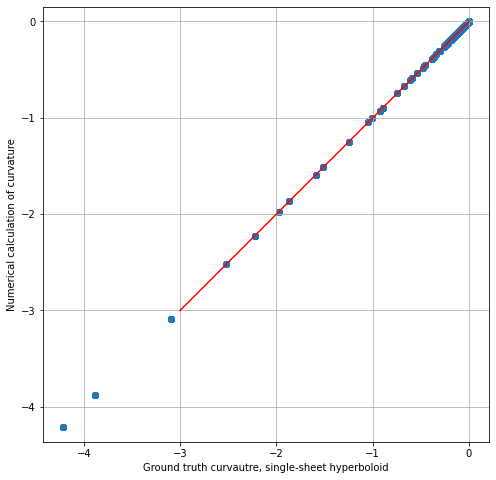

In [15]:
plt.figure(figsize=[8,8])
plt.scatter(kall_analytic.flatten(), kall)
plt.plot([-3,0],[-3,0],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('Ground truth curvautre, single-sheet hyperboloid')
plt.ylabel('Numerical calculation of curvature')
# plt.ylim([-.00003,.00003])

Text(0, 0.5, 'Numerical calculation of curvature')

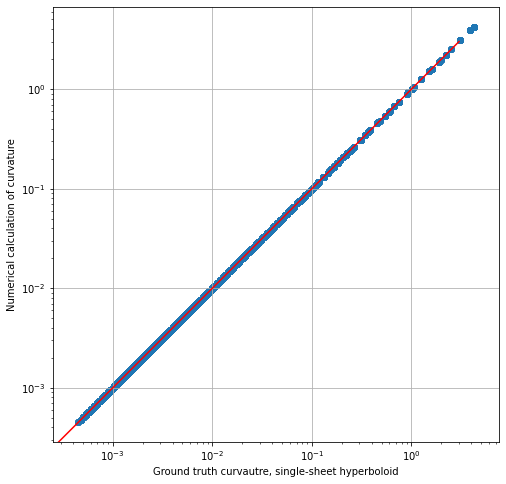

In [16]:
plt.figure(figsize=[8,8])
plt.plot([0,3],[0,3],'r')
plt.scatter(np.abs(kall_analytic.flatten()), np.abs(kall),marker='o')
# plt.
plt.axis('equal')
plt.grid()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Ground truth curvautre, single-sheet hyperboloid')
plt.ylabel('Numerical calculation of curvature')
# plt.ylim([-.00003,.00003])

In [17]:
%matplotlib inline

In [18]:
# plt.contourf(xv,yv,np.abs(zv))
# plt.axis('equal')

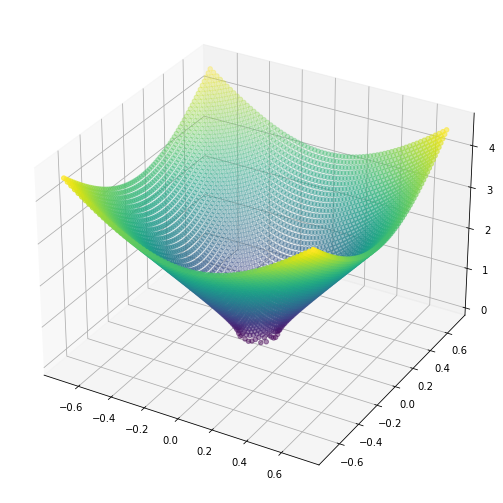

In [19]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize = [9,9])
ax = fig.add_subplot(111, projection='3d')

# plt.contourf(xv,yv,np.abs(zv))
# ax.scatter(xv,yv,zv,c=kall)
ax.scatter(xv,yv,np.abs(zv),c=np.abs(zv[np.logical_not(np.isnan(ygrad[:,:,0]))]))#c=kall_analytic[np.logical_not(np.isnan(ygrad[:,:,0]))]-kall[np.logical_not(np.isnan(ygrad[:,:,0]))])


In [20]:
np.max(np.abs((kall_analytic[np.logical_not(np.isnan(ygrad[:,:,0]))].flatten()- kall[np.logical_not(np.isnan(ygrad[:,:,0]))].flatten()))),#np.mean(np.abs((kall_analytic.flatten()- kall.flatten()))),np.std(np.abs((kall_analytic.flatten()- kall.flatten())))


(3.375077994860476e-14,)

(1e-18, 1e-12)

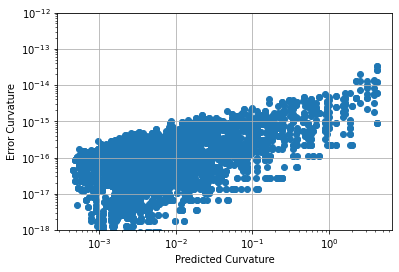

In [21]:
plt.scatter(np.abs(kall.flatten()),np.abs(kall_analytic.flatten()- kall.flatten()))#,bins=40)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Predicted Curvature')
plt.ylabel('Error Curvature')

plt.ylim([1e-18,1e-12])

(1e-16, 1e-12)

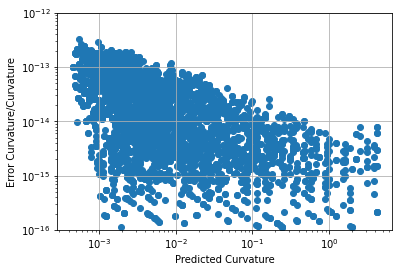

In [22]:
plt.scatter(np.abs(kall.flatten()),np.abs(kall_analytic.flatten()- kall.flatten())/np.abs(kall.flatten()))#,bins=40)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Predicted Curvature')
plt.ylabel('Error Curvature/Curvature')

plt.ylim([1e-16,1e-12])

(1e-16, 1e-12)

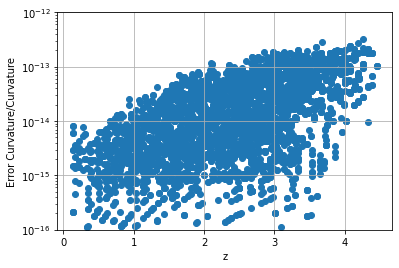

In [23]:
plt.scatter(zv,np.abs(kall_analytic.flatten()- kall.flatten())/np.abs(kall.flatten()))#,bins=40)
# plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('z')
plt.ylabel('Error Curvature/Curvature')
plt.ylim([1e-16,1e-12])

(array([1.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 5.000e+00,
        6.000e+00, 1.300e+01, 1.700e+01, 2.500e+01, 1.900e+01, 3.200e+01,
        4.900e+01, 7.700e+01, 1.160e+02, 1.660e+02, 2.220e+02, 4.670e+02,
        1.349e+03, 9.920e+02, 3.880e+02, 2.700e+02, 1.430e+02, 8.900e+01,
        7.200e+01, 4.400e+01, 4.000e+01, 2.400e+01, 1.200e+01, 1.200e+01,
        2.000e+01, 7.000e+00, 5.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-2.88750009e-13, -2.73476618e-13, -2.58203228e-13, -2.42929837e-13,
        -2.27656446e-13, -2.12383055e-13, -1.97109664e-13, -1.81836274e-13,
        -1.66562883e-13, -1.51289492e-13, -1.36016101e-13, -1.20742710e-13,
        -1.05469319e-13, -9.01959287e-14, -7.49225379e-14, -5.96491471e-14,
        -4.43757563e-14, -2.91023655e-14, -1.38289747e-14,  1.44441614e-15,
         1.67178069e-14,  3.19911977e-14,  4.72645886e-14,  6.25379794e-14,
         7.78113702e-14,  9.30847610e-14,  1.0

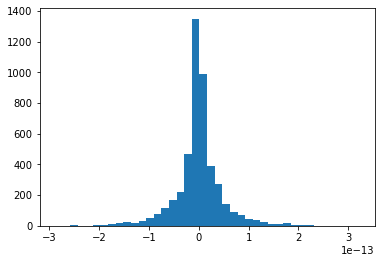

In [24]:
plt.hist((kall_analytic.flatten()- kall.flatten())/kall.flatten(),bins=40)